# Radioactive Decay
We will solve numerically the equation for radioactive decay of isotope A to isotope B and compare the numerical result to its analytical counterpart. We will use Euler's method.

As a second step we will generalize the solver to deal with three elements, where isotope A decays to isotope B and isotope B decays to isotope C. 

In [1]:
# Import some libraries from python and set some defaults
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import sys
import os
import time
sys.path.append(os.getcwd())
# from scipy.interpolate import CubicSpline
import pickle
import copy
plt.rcParams.update({'font.size': 17})
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
rc('animation', html='html5')


In [2]:
# get the base file
import requests
from pathlib import Path
if Path("DEq_Solver.py").is_file():
    print("DEq_Solver already exist")
else:
    print("Downloading the DEq_solver")
    request = requests.get("https://raw.githubusercontent.com/keithonpy/Scientific_Computing/main/Base/DEq_Solver.py")
    with open("DEq_Solver.py", "wb") as f:
        f.write(request.content)
print("Deq_Solver imported")
from DEq_Solver import DEq_Solver

DEq_Solver already exist
Deq_Solver imported


## Euler's method

Euler's method for solving the first order DE


$$\frac{{\rm d}x}{{\rm d}t} = f(x,t)$$ is



$$x^{n+1} = x^{n} + f(x^n,t^n)\,\Delta t$$.

We begin by implementing a routine, ``makeStep``, that implements this time integration, and test it in the special case where
$f(x,t)$ is a constant.


This is where we define the Euler solver. The class Euler Solver below is derived from the more general DEq_Solver class (see DEq_Solver.py in the same directory). This means that the resulting EulerSolver class features all the methods defined in DEq_Solver as well as the additional EulerSolver methods.

Implement the `makeStep(self)` function. Within this function you have access to 

- the current coordinates array as ``self.x``
- the current time as ``self.t``
- the derivative $dx/dt$ as ``self.kernel.dx_dt(self.x,self.t)``
- the timestep as ``self.delta_t``



the function ``makeStep`` has to update ``self.x`` and ``self.t`` using the Euler method for first order DE.

In [3]:
class EulerSolver(DEq_Solver):
    def __init__(self, kernel):
        self.kernel  = kernel
    def makeStep(self):
        ### update the position self.x, given dx_dt=self.kernel.dx_dt(self.x, self.t) and the timestep, self.delta_t
        ### and the timestep
        self.x +=  self.kernel.dx_dt(self.x, self.t) * self.delta_t
        self.t += self.delta_t

Two testing cases for the `makeStep()` routine

In [4]:
class ConstantSpeedKernel:
    def dx_dt(x,t):
        return 2.3
x0=np.array([0.0])
t0=0
t1=10
delta_t=0.1
d=EulerSolver(ConstantSpeedKernel)

d.initialise(x0,t0,t1,delta_t)

# test 20 steps
for i in range(20):
    d.makeStep()
assert np.isclose(d.x,np.array([ 4.6]))

In [5]:
class testKernel:
    def dx_dt(x,t):
        return sum(x)*np.ones_like(x)
    
d=EulerSolver(testKernel)
x0=np.array([1.0,2.0,3.0])
t0=0
t1=10
delta_t=0.1
d.initialise(x0,t0,t1,delta_t)

for i in range(10):
    d.makeStep()

assert np.isclose(d.x,np.array([ 26.57169837,  27.57169837,  28.57169837])).all()

## Radioactive decay

We use the ``EulerSolver`` routine to calculate the radioactive decay of isotope A. 
The mathematical model describing the radioactive decay of A to B is 

$$  \frac{{\rm d}N_A}{{\rm d}t} = -\frac{N_A}{\tau} $$

We will use the solver above but we now need to provide the kernel for this 
specific case -- that is we have to provide the function $f$ in the "canonical form"

$$  \frac{{\rm d}x_i}{{\rm d}t} = f_i(x_i,t)$$


The method `dx_dt(self,x,t)` needs to be modified. 
 
In this case we know the analytical solution so we can compare our numerical result with the analytical formula that you need to implement in ``analytical``

In addition, in the ``__init__`` routine the half-life given by `hlife` needs to be converted into the time constant `tau`. 

All other input, plotting of results, etc. is already implemented in the following cells.

In [6]:
class Radioactive:
    def __init__(self,hlife):        
        # set self.tau, given the half-life, hlife = tau * ln(2)
        self.tau = hlife / np.log(2)

    def dx_dt(self,x,t):
        # return dx/dt, given x, t, and tau
        return - x/ self.tau
        
    def analytical(self,x0,t):
        # return the analytical solution for decay, given x0, t, and tau
        return x0 * np.exp(-t/self.tau)

    def relative_error(self,test,t0,t1):
        res = []
        for t,x in test:
            if len(res)==0:
                x0 = x
            res.append( (t, x/self.analytical(x0,t-t0)-1) )
        return res

Test cases for the radioactive decay

In [7]:
# this checks the tau implementation
r=Radioactive(0.9)
assert np.isclose(r.tau,1.2984255368)

In [8]:
# this checks the kernel implementation
r=Radioactive(0.9)
assert np.isclose(r.dx_dt(5000,1.0),-3850.8176697774734)

## Application

Plot the radioactive decay of some element

In [9]:
# Initial conditions
natoms = 10000   # Original number of elements at time t=t0
hlife  = 0.2     # Half-life of the element
t0     = 0.0     # Initial time
t1     = 1.0     # Final time of simulation
deltat = 0.01    # Size of timestep

In [10]:
radioactive = Radioactive(hlife)
deq_solver  = EulerSolver(radioactive)

# We will now compute the solution for three sizes of the timestep, deltat, delta/10, 5deltat

# first simulation
x0      = np.array([natoms],dtype='f')
result  = deq_solver.solve(x0,t0,t1,deltat)
ts, xs  = zip(*result)
errors  = radioactive.relative_error(result,t0,t1)
te, xe  = zip(*errors)
sim1    = {'t':ts, 'x':xs, 'err':xe}

# second simulation
x0      = np.array([natoms],dtype='f')
result  = deq_solver.solve(x0,t0,t1,deltat/10)
ts, xs  = zip(*result)
errors  = radioactive.relative_error(result,t0,t1)
te, xe  = zip(*errors)
sim2    = {'t':ts, 'x':xs, 'err':xe}

# third simulation
x0      = np.array([natoms],dtype='f')
result  = deq_solver.solve(x0,t0,t1,5*deltat)
ts, xs  = zip(*result)
errors  = radioactive.relative_error(result,t0,t1)
te, xe  = zip(*errors)
sim3     = {'t':ts, 'x':xs, 'err':xe}

(2.3, 4.2)

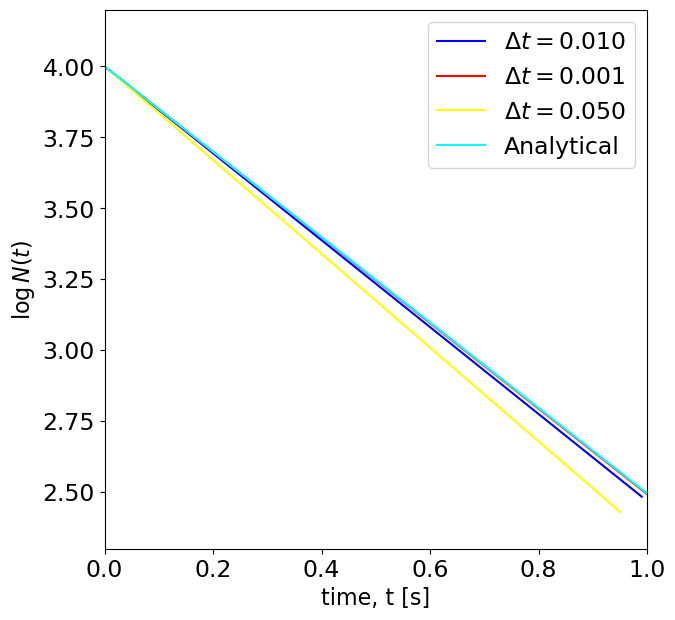

In [12]:
# single figure of size 7x7 cm
fig, ax  = plt.subplots(1, 1, figsize = (7, 7))

# plot first result
label = r"$\Delta t={0:1.3f}$".format(deltat)
ax.plot(sim1["t"], np.log10(sim1["x"]), label=label, color='blue')
        
# plot second result
label = r"$\Delta t={0:1.3f}$".format(deltat/10)
ax.plot(sim2["t"], np.log10(sim2["x"]), label=label, color='red')
        
# plot third result
label = r"$\Delta t={0:1.3f}$".format(5*deltat)
ax.plot(sim3["t"], np.log10(sim3["x"]), label=label, color='yellow')
        
# Analytical result
t  = np.arange(t0,t1,deltat/100)
x  = radioactive.analytical(natoms,t)
label = 'Analytical'
ax.plot(t, np.log10(x), label=label, color='cyan')

# generate legend
ax.legend()

# axis labels
ax.set_xlabel("time, t [s]")
ax.set_ylabel(r"$\log N(t)$")

# limits
ax.set_xlim([0,1])
ax.set_ylim([2.3,4.2])



Text(0, 0.5, 'relative error')

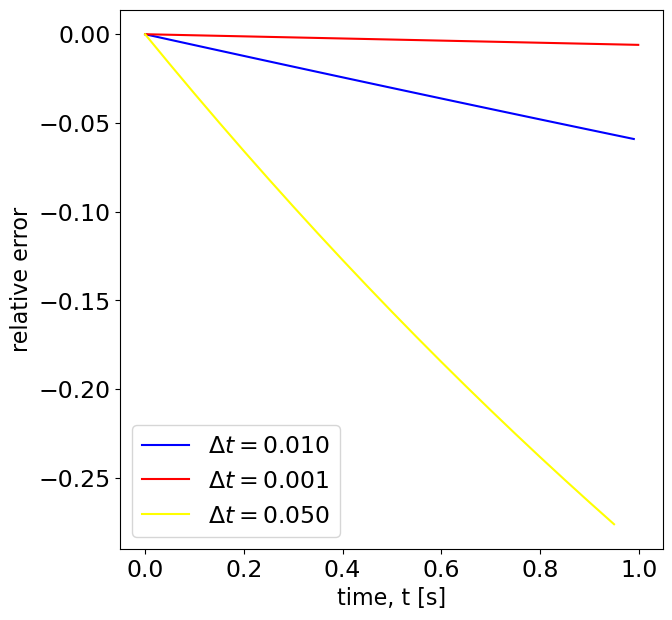

In [14]:
# plot the relative difference between numerical integration and analytical result

# single figure of size 7x7 cm
fig, ax  = plt.subplots(1, 1, figsize = (7, 7))

# plot first result
label = r"$\Delta t={0:1.3f}$".format(deltat)
ax.plot(sim1["t"], sim1["err"], label=label, color='blue')
        
# plot second result
label = r"$\Delta t={0:1.3f}$".format(deltat/10)
ax.plot(sim2["t"], sim2["err"], label=label, color='red')
        
# plot third result
label = r"$\Delta t={0:1.3f}$".format(5*deltat)
ax.plot(sim3["t"], sim3["err"], label=label, color='yellow')
        

# generate legend
ax.legend()

# axis labels
ax.set_xlabel("time, t [s]")
ax.set_ylabel(r"relative error")


## Radioactive decay: three isotopes

Generalise the `Radioactive` class to a new class, `RadioactiveABC`, which is able treat a problem with three types of isotopes named A, B and C:

- A decays to B with half-life $h_A$
- B decays to C with half-life $h_B$ 

We start with 1000000 isotopes of type A, and none of types B nor C. 
There is no need to implement an analytical solution. You should be able to re-use ``EulerSolver`` (hint: ``self.x`` can be an array, for example containing $N_A$, $N_B$ and $N_C$).

You will have to add new empty cells below to implement your solution. Begin by creating a markdown cell with the equations you are intending to implement.

Create a plot of the abundances of istopes as a function of time. Execute this cell, and the two hidden cells below, in case the two multiple-choice questions are not visible. Use your code to help you answer the questions.

In [26]:
class RadioactiveABC:
    def __init__(self,hlifeA,hlifeB):
        self.tauA = hlifeA / np.log(2)
        self.tauB = hlifeB / np.log(2)


    def dx_dt(self,x,t):
        # return dx/dt as a numpy array, given
        # tauA, tauB and x
        return np.array([-x[0]/self.tauA, x[0]/self.tauA - x[1]/self.tauB, x[1]/self.tauB])

In [30]:
# run the simulations

hlifeAs=[0.7, 0.3]
hlifeBs=[0.9, 0.2]

Result = {}
for (hlifeA, hlifeB) in zip(hlifeAs, hlifeBs):
    rABC    = RadioactiveABC(hlifeA,hlifeB)
    solver  = EulerSolver(rABC)

    x0     = np.array([1000000,0,0],dtype='f')
    result = solver.solve(x0,0,5,0.01)

    na,nb,nc =solver.coordinateSteps()
    ts=solver.timeSteps()
    Result[hlifeA] = {}
    Result[hlifeA]["na"] = na
    Result[hlifeA]["nb"] = nb
    Result[hlifeA]["nc"] = nc
    Result[hlifeA]["ts"] = ts

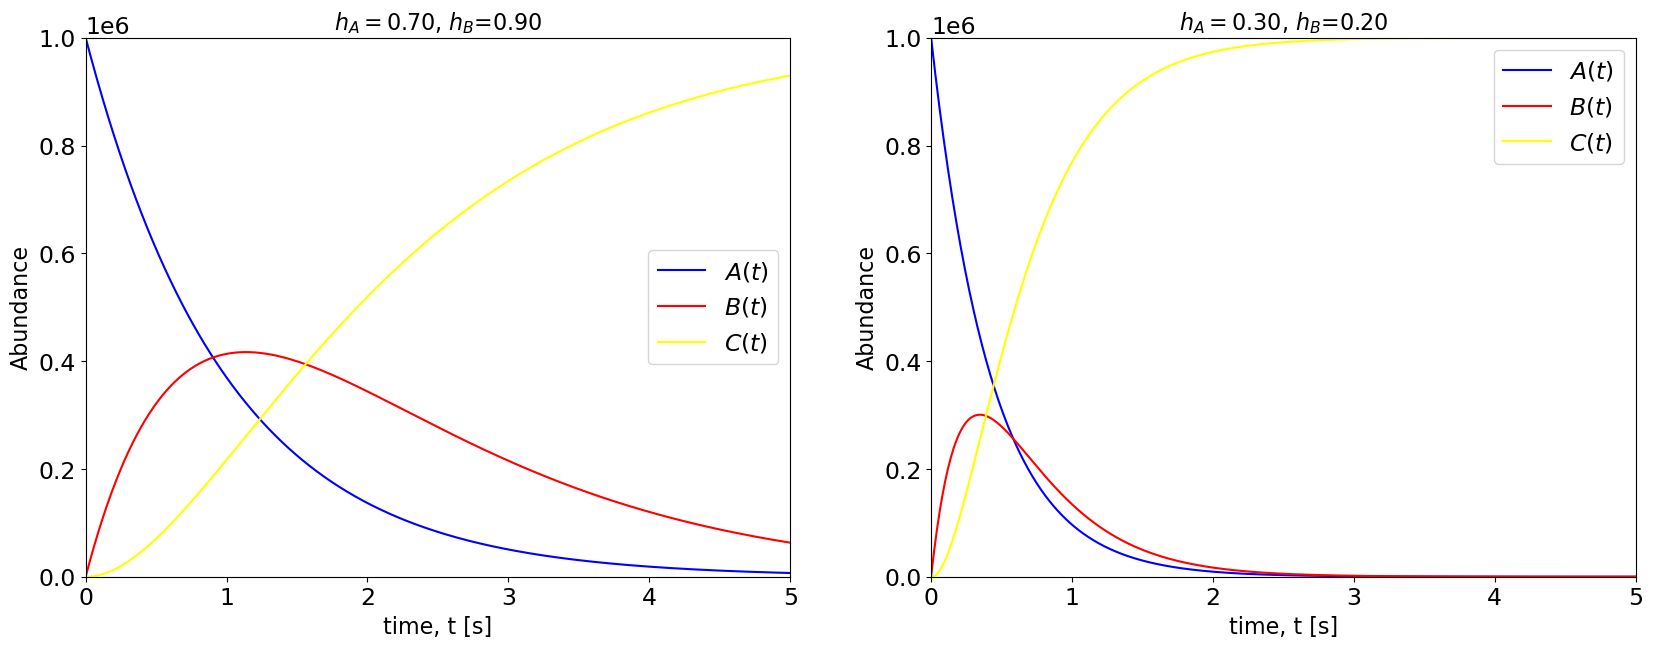

In [28]:
# plot the result

# single figure of size 7x7 cm
fig, ax  = plt.subplots(1, 2, figsize = (20, 7))

# evolution of A
panels = np.arange(2)
for (hlifeA, hlifeB, panel) in zip(hlifeAs, hlifeBs, panels):
    na = Result[hlifeA]["na"]
    nb = Result[hlifeA]["nb"]
    nc = Result[hlifeA]["nc"]
    ts = Result[hlifeA]["ts"]
    
    label = r"$A(t)$"
    ax[panel].plot(ts, na, label=label, color='blue')
        
    # evolution of B
    label = r"$B(t)$"
    ax[panel].plot(ts, nb, label=label, color='red')
        
    # evolution of C
    label = r"$C(t)$"
    ax[panel].plot(ts, nc, label=label, color='yellow')
        
    # generate legend
    ax[panel].legend()

    # axis labels
    ax[panel].set_xlabel("time, t [s]")
    ax[panel].set_ylabel(r"Abundance")

# limits
    ax[panel].set_xlim([0,5])
    ax[panel].set_ylim([0,1000000])

    title = r"$h_A=${0:1.2f}, $h_B$={1:1.2f}".format(hlifeA, hlifeB)
    ax[panel].set_title(title)

## Playground


This is suggestion for yet another exercise

The number of individuals in a population, $N$, changes because of births and deaths. Suppose this is described as


$\frac{{\rm d}N}{{\rm d}t} = a N - b N^2$

where $a=10$ and $b=0.01$. Starting from $N=100$, evaluate the evolution of $N$. First analyse the expected behaviour, for example, is there an equilibrium population number? And what is the time-scale fo reaching this equilibrium.


In [34]:
class Radioactive_play:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def dx_dt(self, x, t):
        # return dx/dt given a, b, x
        return self.a * x - self.b*x**2

In [61]:
# initial condition
natoms = 10000   # Original number of elements at time t=t0
t0     = 0.0     # Initial time
t1     = 1.0     # Final time of simulation
deltat = 0.01    # Size of timestep
a      = 10
b      = 0.01

In [62]:
# run the simulations


Result = {}

r_play    = Radioactive_play(a, b)
solver  = EulerSolver(r_play)

x0     = np.array([natoms],dtype='f')
result = solver.solve(x0,t0,t1,deltat)

ts, xs  = zip(*result)
errors  = radioactive.relative_error(result,t0,t1)
te, xe  = zip(*errors)
sim     = {'t':ts, 'x':xs, 'err':xe}

(0.0, 1.0)

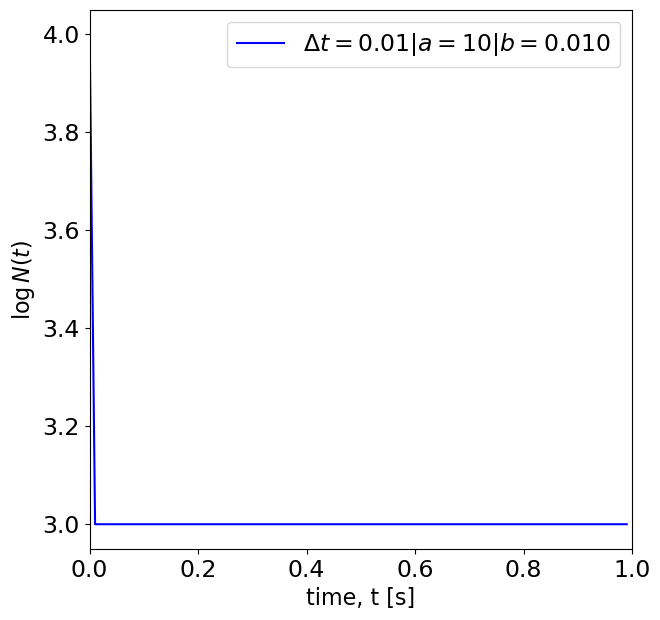

In [63]:
# single figure of size 7x7 cm
fig, ax  = plt.subplots(1, 1, figsize = (7, 7))

# plot result
label = r"$\Delta t=0.01| a = {0} | b= {1:1.3f}$".format(a, b)
ax.plot(sim["t"], np.log10(sim["x"]), label=label, color='blue')

# generate legend
ax.legend()

# axis labels
ax.set_xlabel("time, t [s]")
ax.set_ylabel(r"$\log N(t)$")

# limits
ax.set_xlim([0,1])
